In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import PIL.Image
import collections
import os

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# VGG19
The pre-trained VGG19 Model for TensorFlow.

download URL : http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat

In [2]:
MODEL_FILE_NAME = 'deep_vgg19.mat'

In [3]:
def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)

In [4]:
def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

In [5]:
class VGG19:

    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    def __init__(self, data_path):
        data = scipy.io.loadmat(data_path)

        self.mean_pixel = np.array([123.68, 116.779, 103.939])

        self.weights = data['layers'][0]

    def preprocess(self, image):
        return image - self.mean_pixel

    def undo_preprocess(self,image):
        return image + self.mean_pixel

    def feed_forward(self, input_image, scope = None):
        net = {}
        current = input_image

        with tf.variable_scope(scope):
            for i, name in enumerate(self.layers):
                kind = name[:4]
                if kind == 'conv':
                    kernels = self.weights[i][0][0][2][0][0]
                    bias = self.weights[i][0][0][2][0][1]

                    # matconvnet: weights are [width, height, in_channels, out_channels]
                    # tensorflow: weights are [height, width, in_channels, out_channels]
                    kernels = np.transpose(kernels, (1, 0, 2, 3))
                    bias = bias.reshape(-1)

                    current = _conv_layer(current, kernels, bias)
                elif kind == 'relu':
                    current = tf.nn.relu(current)
                elif kind == 'pool':
                    current = _pool_layer(current)
                net[name] = current

        assert len(net) == len(self.layers)
        return net

# Helper-functions for image manipulation

This function loads an image and returns it as a numpy array of floating-points.

The image can be automatically resized so the largest of the height or width equals max_size, or resized to the given shape

In [6]:
def load_image(filename, shape = None, max_size = None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor while keeping the proportion between them.
        factor = float(max_size) / np.max(image.size)

        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)
    
    if shape is not None:
        image = image.resize(shape, PIL.Image.LANCZOS)
    
    # Convert to numpy floating-point array.
    return np.float32(image)

This function saves an image as a jpeg-file with pixel-values between 0 and 255.

In [7]:
def save_image(image, filename):
    
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert to bytes.
    image = image.astype(np.uint8)

    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

This function plots the final mixed image.

In [8]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

This function plots the content-, mixed- and style-images.

In [9]:
def plot_images(content_image, style_image, mixed_image):
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Output")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# style-transfer

The style-fransfer algorithm uses gradient descent to find an image that minimizes the loss-functions of the content-layers and style-layers.

In [10]:
class StyleTransfer:

    def __init__(self, session, net, 
                 content_layer_ids, style_layer_ids, 
                 init_image, content_image, style_image,
                 num_iter, alpha, beta ,content_loss_norm_type):
        """
        Parameters:
        content_layer_ids: List of strings identifying the content-layers.
        style_layer_ids: List of strings identifying the style-layers.
        content_image: Numpy 3-dim float-array with the content-image.
        style_image: Numpy 3-dim float-array with the style-image.
        init_image: Numpy 3-dim float-array with the initial-image.
        num_iter: Number of optimization iterations to perform.
        weight: A list of weights of content-loss and style-loss.
        content_loss_norm_type: ifferent types of normalization for content loss.
        """

        self.net = net
        self.sess = session

        # sort layers info
        self.CONTENT_LAYERS = collections.OrderedDict(sorted(content_layer_ids.items()))
        self.STYLE_LAYERS = collections.OrderedDict(sorted(style_layer_ids.items()))

        # preprocess input images
        self.p0 = np.float32(self.net.preprocess(content_image))
        self.a0 = np.float32(self.net.preprocess(style_image))
        self.x0 = np.float32(self.net.preprocess(init_image))

        # parameters for optimization
        self.content_loss_norm_type = content_loss_norm_type
        self.num_iter = num_iter
        self.alpha = alpha
        self.beta = beta

        # build graph for style transfer
        self._build_graph()

    def _build_graph(self):

        self.x = tf.Variable(self.x0, trainable=True, dtype=tf.float32)

        # graph input
        self.p = tf.placeholder(tf.float32, shape=self.p0.shape, name='content')
        self.a = tf.placeholder(tf.float32, shape=self.a0.shape, name='style')

        # get content-layer-feature for content loss
        content_layers = self.net.feed_forward(self.p, scope='content')
        self.Ps = {}
        for id in self.CONTENT_LAYERS:
            self.Ps[id] = content_layers[id]

        # get style-layer-feature for style loss
        style_layers = self.net.feed_forward(self.a, scope='style')
        self.As = {}
        for id in self.STYLE_LAYERS:
            self.As[id] = self._gram_matrix(style_layers[id])
        
        # get layer-values for x
        self.Fs = self.net.feed_forward(self.x, scope='mixed')

        """ compute total loss """
        L_content = 0
        L_style = 0
        for id in self.Fs:
            if id in self.CONTENT_LAYERS:
                
                ## content loss ##

                F = self.Fs[id]            # content feature of x
                P = self.Ps[id]            # content feature of p

                _, h, w, d = F.get_shape() # first return value is batch size
                N = h.value*w.value        # product of width and height
                M = d.value                # number of filters

                w = self.CONTENT_LAYERS[id]# weight for this layer

                # Different normalization constant
                if self.content_loss_norm_type==1:
                    L_content += w * tf.reduce_sum(tf.pow((F-P), 2)) / 2
                elif self.content_loss_norm_type == 2:
                    L_content += w * tf.reduce_sum(tf.pow((F-P), 2)) / (N*M)
                elif self.content_loss_norm_type == 3:
                    L_content += w * (1. / (2. * np.sqrt(M) * np.sqrt(N))) * tf.reduce_sum(tf.pow((F - P), 2))

            elif id in self.STYLE_LAYERS:
                
                ## style loss ##

                F = self.Fs[id]

                _, h, w, d = F.get_shape()  # first return value is batch size
                N = h.value * w.value       # product of width and height
                M = d.value                 # number of filters

                w = self.STYLE_LAYERS[id]   # weight for this layer

                G = self._gram_matrix(F)    # style feature of x
                A = self.As[id]             # style feature of a

                L_style += w * (1. / (4 * N ** 2 * M ** 2)) * tf.reduce_sum(tf.pow((G-A), 2))

        alpha = self.alpha
        beta = self.beta
        
        self.L_content = L_content
        self.L_style = L_style
        self.L_total = alpha*L_content + beta*L_style

    def update(self):
        
        # define optimizer L-BFGS
        
        global _iter
        _iter = 0
        def callback(tl, cl, sl):
            global _iter
            print('.', end = "")
            if _iter % 10 == 0:
                print()
                print('iter : %4d, ' % _iter, 'L_total : %g, L_content : %g, L_style : %g' % (tl, cl, sl))
            _iter += 1

        optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.L_total, method='L-BFGS-B', options={'maxiter': self.num_iter})

        # initialize variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        # optmization
        optimizer.minimize(self.sess,feed_dict={self.a:self.a0, self.p:self.p0},
                           fetches=[self.L_total, self.L_content, self.L_style], loss_callback=callback)

        # get final result
        final_image = self.sess.run(self.x)

        # ensure the image has valid pixel-values between 0 and 255
        final_image = np.clip(self.net.undo_preprocess(final_image), 0.0, 255.0)

        return final_image

    def _gram_matrix(self, tensor):

        shape = tensor.get_shape()

        # Get the number of feature channels for the input tensor.
        num_channels = int(shape[3])

        # Reshape the tensor so it is a 2-dim matrix.
        matrix = tf.reshape(tensor, shape=[-1, num_channels])

        # Calculate the Gram-matrix.
        gram = tf.matmul(tf.transpose(matrix), matrix)

        return gram

# main

This function adds one dim for batch, because VGG19 requires input dimension to be (batch, height, width, channel).

In [11]:
def add_one_dim(image):
    shape = (1,) + image.shape
    return np.reshape(image, shape)

Input parameters.

In [12]:
args = {'model_path' : 'vgg19_model',
        'content'    : 'images/content.jpg',
        'style'      : 'images/style2.jpg',
        'output'     : 'output/result02+.jpg',
        'alpha'      : 1,
        'beta'       : 0,
        'content_layers':['relu1_2'],
        'style_layers':['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
        'content_layer_weights':[1.0],
        'style_layer_weights':[.2,.2,.2,.2,.2],
        'initial_type': 'random',
        'max_size'   : 512,
        'content_loss_norm_type': 3,
        'num_iter': 1000
        }

Example

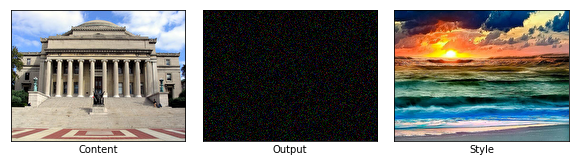

.
iter :    0,  L_total : 1.15068e+08, L_content : 1.15068e+08, L_style : 1.74212e+11
..........
iter :   10,  L_total : 3.75599e+07, L_content : 3.75599e+07, L_style : 1.50615e+10
..........
iter :   20,  L_total : 1.26945e+07, L_content : 1.26945e+07, L_style : 5.88597e+09
..........
iter :   30,  L_total : 6.25578e+06, L_content : 6.25578e+06, L_style : 5.95469e+09
..........
iter :   40,  L_total : 3.07086e+06, L_content : 3.07086e+06, L_style : 6.23157e+09
..........
iter :   50,  L_total : 1.24401e+06, L_content : 1.24401e+06, L_style : 6.38708e+09
..........
iter :   60,  L_total : 112332, L_content : 112332, L_style : 6.47556e+09
..........
iter :   70,  L_total : 37696.2, L_content : 37696.2, L_style : 6.53122e+09
..........
iter :   80,  L_total : 22572.1, L_content : 22572.1, L_style : 6.55539e+09
..........
iter :   90,  L_total : 15220.4, L_content : 15220.4, L_style : 6.56463e+09
.

In [ ]:
# initiate VGG19 model
model_file_path = args['model_path'] + '/' + MODEL_FILE_NAME
vgg_net = VGG19(model_file_path)

# load content image and style image
content_image = load_image(args['content'], max_size=args['max_size'])
style_image = load_image(args['style'], shape=(content_image.shape[1],content_image.shape[0]))

# initial guess for output
if args['initial_type'] == 'content':
    init_image = content_image
elif args['initial_type'] == 'style':
    init_image = style_image
elif args['initial_type'] == 'random':
    init_image = np.random.normal(size=content_image.shape, scale=np.std(content_image))

# check input images for style-transfer
plot_images(content_image,style_image, init_image)

# create a map for content layers info
CONTENT_LAYERS = {}
for layer, weight in zip(args['content_layers'],args['content_layer_weights']):
    CONTENT_LAYERS[layer] = weight

# create a map for style layers info
STYLE_LAYERS = {}
for layer, weight in zip(args['style_layers'], args['style_layer_weights']):
    STYLE_LAYERS[layer] = weight


# open session
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    
# build the graph
st = StyleTransfer(session = sess,
                   content_layer_ids = CONTENT_LAYERS,
                   style_layer_ids = STYLE_LAYERS,
                   init_image = add_one_dim(init_image),
                   content_image = add_one_dim(content_image),
                   style_image = add_one_dim(style_image),
                   net = vgg_net,
                   num_iter = args['num_iter'],
                   alpha = args['alpha'],
                   beta = args['beta'],
                   content_loss_norm_type = args['content_loss_norm_type'],
                                      )
# launch the graph in a session
result_image = st.update()

# close session
sess.close()

# remove batch dimension
shape = result_image.shape
result_image = np.reshape(result_image,shape[1:])

# save result
save_image(result_image,args['output'])
plot_images(content_image, style_image, result_image)